In [1]:
from google.colab import drive
import shutil, zipfile, os

drive.mount('/content/drive')
shutil.copy("/content/drive/MyDrive/DATASET.zip", "/content/")
with zipfile.ZipFile("DATASET.zip", 'r') as zip_ref:
    zip_ref.extractall("dataset")

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam


In [3]:
def load_images_from_folder(folder_path, image_size=(224, 224)):
    X, y = [], []
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: idx for idx, name in enumerate(class_names)}
    for class_name in class_names:
        class_folder = os.path.join(folder_path, class_name)
        for filename in os.listdir(class_folder):
            try:
                img_path = os.path.join(class_folder, filename)
                img = Image.open(img_path).convert('RGB').resize(image_size)
                X.append(np.array(img))
                y.append(class_map[class_name])
            except:
                continue
    return np.array(X), np.array(y), class_map

X, y, class_map = load_images_from_folder("dataset/DATASET")
class_names = list(class_map.keys())
X = preprocess_input(X)  # EfficientNet expects special preprocessing

# Split data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=1/3, stratify=y_temp, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# Image augmentation
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

In [4]:
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
base_model.trainable = False

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer=Adam(1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_val, y_val),
                    epochs=30,
                    class_weight=class_weights)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step - accuracy: 0.1343 - loss: 3.1133 - val_accuracy: 0.4500 - val_loss: 1.9520
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 387ms/step - accuracy: 0.4757 - loss: 1.6126 - val_accuracy: 0.6950 - val_loss: 1.5660
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 336ms/step - accuracy: 0.6526 - loss: 1.0716 - val_accuracy: 0.7650 - val_loss: 1.2928
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 402ms/step - accuracy: 0.7455 - loss: 0.8245 - val_accuracy: 0.8150 - val_loss: 1.0770
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 375ms/step - accuracy: 0.8152 - loss: 0.6191 - val_accuracy: 0.8250 - val_loss: 0.9152
Epoch 6/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 349ms/step - accuracy: 0.8188 - loss: 0.5263 - val_accuracy: 0.8300 - val_loss: 0.7749
Epoch 7/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 399ms/step - accuracy: 0.8820 - loss: 0.3967 - val_accuracy: 0.8400 - val_loss: 0.6713
Epoch 8/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 336ms/step - accuracy: 0.8390 - loss: 0.4892 - val_accuracy: 0.84

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False
model.compile(optimizer=Adam(1e-5), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history_fine = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                         validation_data=(X_val, y_val),
                         epochs=10,
                         class_weight=class_weights)

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 59s 2s/step - accuracy: 0.7660 - loss: 0.7842 - val_accuracy: 0.9350 - val_loss: 0.2632
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.7797 - loss: 0.6810 - val_accuracy: 0.9300 - val_loss: 0.2793
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.8106 - loss: 0.6236 - val_accuracy: 0.9300 - val_loss: 0.2940
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 8s 384ms/step - accuracy: 0.8341 - loss: 0.5632 - val_accuracy: 0.9300 - val_loss: 0.3116
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.8524 - loss: 0.5341 - val_accuracy: 0.9150 - val_loss: 0.3262
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 397ms/step - accuracy: 0.8482 - loss: 0.5977 - val_accuracy: 0.9100 - val_loss: 0.3360
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 329ms/step - accuracy: 0.8519 - loss: 0.5117 - val_accuracy: 0.9100 - val_loss: 0.3475
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 330ms/step - accuracy: 0.8817 - loss: 0.3726 - val_accuracy: 0.9

In [ ]:

test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"✅ Test Accuracy: {test_acc:.4f}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.8586 - loss: 0.4656
✅ Test Accuracy: 0.8600


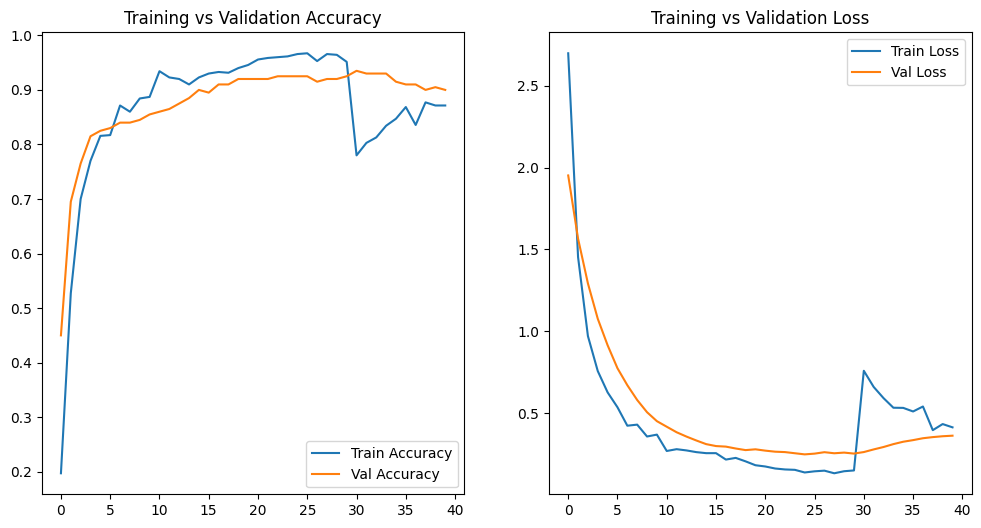

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + history_fine.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + history_fine.history['val_loss'], label='Val Loss')
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Collab Notebooks/efficientnet_fashion_model.h5')


In [ ]:
!pip install gradio --quiet
import gradio as gr
model = tf.keras.models.load_model('/content/drive/My Drive/Collab Notebooks/efficientnet_fashion_model.h5')

def predict_fashion(img):
    img = img.resize((224, 224))
    img_array = preprocess_input(np.expand_dims(np.array(img), axis=0))
    prediction = model.predict(img_array)[0]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)
    return f"Predicted: {predicted_class} ({confidence * 100:.2f}%)"

gr.Interface(
    fn=predict_fashion,
    inputs=gr.Image(type="pil"),
    outputs=gr.Textbox(),
    title="EfficientNet Fashion Classifier",
    description="Upload a fashion item image to get the predicted category."
).launch(share=True)

In [ ]:
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, classification_report
)
import numpy as np

# Predict probabilities
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
test_preds = model.predict(X_test)

# Convert probabilities to predicted class labels
train_preds_class = np.argmax(train_preds, axis=1)
val_preds_class = np.argmax(val_preds, axis=1)
test_preds_class = np.argmax(test_preds, axis=1)

# True labels (assuming already integers)
y_train_class = y_train
y_val_class = y_val
y_test_class = y_test

# AUC Scores
train_auc = roc_auc_score(y_train, train_preds, multi_class='ovr')
val_auc = roc_auc_score(y_val, val_preds, multi_class='ovr')
test_auc = roc_auc_score(y_test, test_preds, multi_class='ovr')

# Accuracy
train_accuracy = np.mean(train_preds_class == y_train_class)
val_accuracy = np.mean(val_preds_class == y_val_class)
test_accuracy = np.mean(test_preds_class == y_test_class)

# Loss
train_loss = model.evaluate(X_train, y_train, verbose=0)[0]
val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
test_loss = model.evaluate(X_test, y_test, verbose=0)[0]

# Precision, Recall, F1-Score (Weighted & Macro)
precision_weighted = precision_score(y_test_class, test_preds_class, average='weighted')
recall_weighted = recall_score(y_test_class, test_preds_class, average='weighted')
f1_weighted = f1_score(y_test_class, test_preds_class, average='weighted')

precision_macro = precision_score(y_test_class, test_preds_class, average='macro')
recall_macro = recall_score(y_test_class, test_preds_class, average='macro')
f1_macro = f1_score(y_test_class, test_preds_class, average='macro')

# Sensitivity = Recall (Weighted)
sensitivity = recall_weighted

# Specificity (approximate for multiclass): TN / (TN + FP) averaged
conf_matrix = confusion_matrix(y_test_class, test_preds_class)
FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
TP = np.diag(conf_matrix)
TN = conf_matrix.sum() - (FP + FN + TP)
specificity = np.mean(TN / (TN + FP))

# Classification Miss Rate
miss_rate = 1 - sensitivity

# Output all metrics
print(f"🔹 AUC - Train: {train_auc:.4f}, Validation: {val_auc:.4f}, Test: {test_auc:.4f}")
print(f"🔹 Accuracy - Train: {train_accuracy:.4f}, Validation: {val_accuracy:.4f}, Test: {test_accuracy:.4f}")
print(f"🔹 Loss - Train: {train_loss:.4f}, Validation: {val_loss:.4f}, Test: {test_loss:.4f}")
print(f"🔹 Precision (Weighted): {precision_weighted:.4f}, (Macro): {precision_macro:.4f}")
print(f"🔹 Recall (Sensitivity) (Weighted): {recall_weighted:.4f}, (Macro): {recall_macro:.4f}")
print(f"🔹 F1-Score (Weighted): {f1_weighted:.4f}, (Macro): {f1_macro:.4f}")
print(f"🔹 Specificity (approx): {specificity:.4f}")
print(f"🔹 Classification Miss Rate: {miss_rate:.4f}")
print("\n🔹 Confusion Matrix:\n", conf_matrix)
print("\n🔹 Classification Report:\n", classification_report(y_test_class, test_preds_class))


22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 540ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 551ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
🔹 AUC - Train: 0.9991, Validation: 0.9840, Test: 0.9814
🔹 Accuracy - Train: 0.9714, Validation: 0.8800, Test: 0.8400
🔹 Loss - Train: 0.1308, Validation: 0.3896, Test: 0.4119
🔹 Precision (Weighted): 0.8491, (Macro): 0.8291
🔹 Recall (Sensitivity) (Weighted): 0.8400, (Macro): 0.8200
🔹 F1-Score (Weighted): 0.8409, (Macro): 0.8209
🔹 Specificity (approx): 0.9823
🔹 Classification Miss Rate: 0.1600

🔹 Confusion Matrix:
 [[10  0  0  0  0  0  0  0  0  0]
 [ 0  6  0  0  0  0  0  4  0  0]
 [ 0  0 15  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0  0  0  2]
 [ 0  0  0  0  9  0  0  1  0  0]
 [ 1  0  0  0  0  9  0  0  0  0]
 [ 1  0  0  0  1  0  8  0  0  0]
 [ 0  2  0  0  0  0  1  7  0  0]
 [ 1  0  0  0  0  0  0  0  9  0]
 [ 0  0  0  2  0  0  0  0  0  8]]

🔹 Classification Report:
               precision    recall  f1-score   support

           0       0.77      1.00      0.87        10


In [ ]:
from sklearn.metrics import (
    confusion_matrix, fbeta_score, precision_score, recall_score, f1_score
)
import numpy as np

# Predict classes
test_preds = model.predict(X_test)
test_preds_class = np.argmax(test_preds, axis=1)
y_true = y_test  # assumed to be integer-encoded

# Confusion Matrix
cm = confusion_matrix(y_true, test_preds_class)
TP = np.diag(cm)
FP = cm.sum(axis=0) - TP
FN = cm.sum(axis=1) - TP
TN = cm.sum() - (FP + FN + TP)

# Small value to prevent divide-by-zero
eps = 1e-10

# F2-Score (beta=2)
f2_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=2)

# Fβ-Score for general beta (set your desired beta)
beta = 0.5
f_beta_score_weighted = fbeta_score(y_true, test_preds_class, average='weighted', beta=beta)

# Positive Predictive Value (Precision)
ppv = precision_score(y_true, test_preds_class, average='weighted')

# Negative Predictive Value (NPV)
npv = np.mean(TN / (TN + FN + eps))

# False Positive Rate (FPR)
fpr = np.mean(FP / (FP + TN + eps))

# False Negative Rate (FNR)
fnr = np.mean(FN / (FN + TP + eps))

# Likelihood Ratios
sensitivity = recall_score(y_true, test_preds_class, average='weighted')
specificity = np.mean(TN / (TN + FP + eps))

lr_positive = sensitivity / (1 - specificity + eps)
lr_negative = (1 - sensitivity) / (specificity + eps)

# Fowlkes–Mallows Index (FMI)
precision_macro = precision_score(y_true, test_preds_class, average='macro')
recall_macro = recall_score(y_true, test_preds_class, average='macro')
fmi = np.sqrt(precision_macro * recall_macro)

# Print Results
print(f"🔹 F2-Score (Weighted): {f2_score_weighted:.4f}")
print(f"🔹 F{beta}-Score (Weighted): {f_beta_score_weighted:.4f}")
print(f"🔹 Positive Predictive Value (PPV): {ppv:.4f}")
print(f"🔹 Negative Predictive Value (NPV): {npv:.4f}")
print(f"🔹 False Positive Rate (FPR): {fpr:.4f}")
print(f"🔹 False Negative Rate (FNR): {fnr:.4f}")
print(f"🔹 Likelihood Ratio Positive (LR+): {lr_positive:.4f}")
print(f"🔹 Likelihood Ratio Negative (LR−): {lr_negative:.4f}")
print(f"🔹 Fowlkes–Mallows Index (FMI): {fmi:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
🔹 F2-Score (Weighted): 0.8395
🔹 F0.5-Score (Weighted): 0.8450
🔹 Positive Predictive Value (PPV): 0.8491
🔹 Negative Predictive Value (NPV): 0.9824
🔹 False Positive Rate (FPR): 0.0177
🔹 False Negative Rate (FNR): 0.1800
🔹 Likelihood Ratio Positive (LR+): 47.5629
🔹 Likelihood Ratio Negative (LR−): 0.1629
🔹 Fowlkes–Mallows Index (FMI): 0.8246
